In [1]:
import glob

import torch
import numpy as np
from scipy.io import loadmat

from timedenoiser.models.cnn import ShallowCNN
from timedenoiser.models.encdec import *
from timedenoiser.models.unet import UNET_1D
from timedenoiser.models.ekf import ekf
from timedenoiser.models.tv1d import tv
from timedenoiser.models.wt import wt

from motormetrics.ml import *
from motormetrics.ee import *

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# !cat ../../../datasets/Data_27012021_noisy/metadata.json

In [3]:
model_id = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_ud = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')
model_uq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt')

# model_id = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/light_encdec/light_encdec_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

# model_id = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_iq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_current_q_outQuants_current_q_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_ud = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_d_outQuants_voltage_d_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
# model_uq = torch.load('../../weights/encdec_skip/encdec_skip_act_relu_stride_1_window_250_inpQuants_noisy_voltage_q_outQuants_voltage_q_lr_0.01_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_id.eval()
model_iq.eval()
model_ud.eval()
model_uq.eval()

model_spd = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_current_d,current_q,voltage_d,voltage_q_outQuants_speed_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)
model_trq = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_250_inpQuants_noisy_current_d,noisy_current_q,noisy_voltage_d,noisy_voltage_q_outQuants_torque_lr_0.1_batchSize_128_epochs_100_loss_mse.pt').cuda(0)

model_spd.eval()
model_trq.eval()

ShallowEncDec(
  (cnn1): Conv1d(4, 32, kernel_size=(10,), stride=(1,))
  (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
  (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
  (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
  (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
  (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
  (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
  (act): ReLU()
)

In [4]:
class Exper():
        def __init__(self, kwargs):
            for k in kwargs:
                self.__dict__[k] = kwargs[k]
                
def compute_ml(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    print ('Speed')
    print ('SMAPE :', smape(speed_pred, ndata['speed']))
    print ('R2 :', r2(speed_pred, ndata['speed']))
    print ('RMSE :', rmse(speed_pred, ndata['speed']))
    print ('MAE :', mae(speed_pred, ndata['speed']))

    print ('Torque')
    print ('SMAPE :', smape(torque_pred, ndata['torque']))
    print ('R2 :', r2(torque_pred, ndata['torque']))
    print ('RMSE :', rmse(torque_pred, ndata['torque']))
    print ('MAE :', mae(torque_pred, ndata['torque']))
    
def compute_ee(data, speed_pred, torque_pred):
    ndata = {}
    for k in data.keys():
        if '__' not in k:
            ndata[k] = data[k][0]

    ndata['speed'] = speed_pred
    ndata['torque'] = torque_pred
    model_exp = Exper(ndata)

    model_torque_metrics = compute_torque_metrics(model_exp)
    model_speed_metrics = compute_speed_metrics(model_exp)

    print (model_speed_metrics)
    print (model_torque_metrics)

bench5.mat


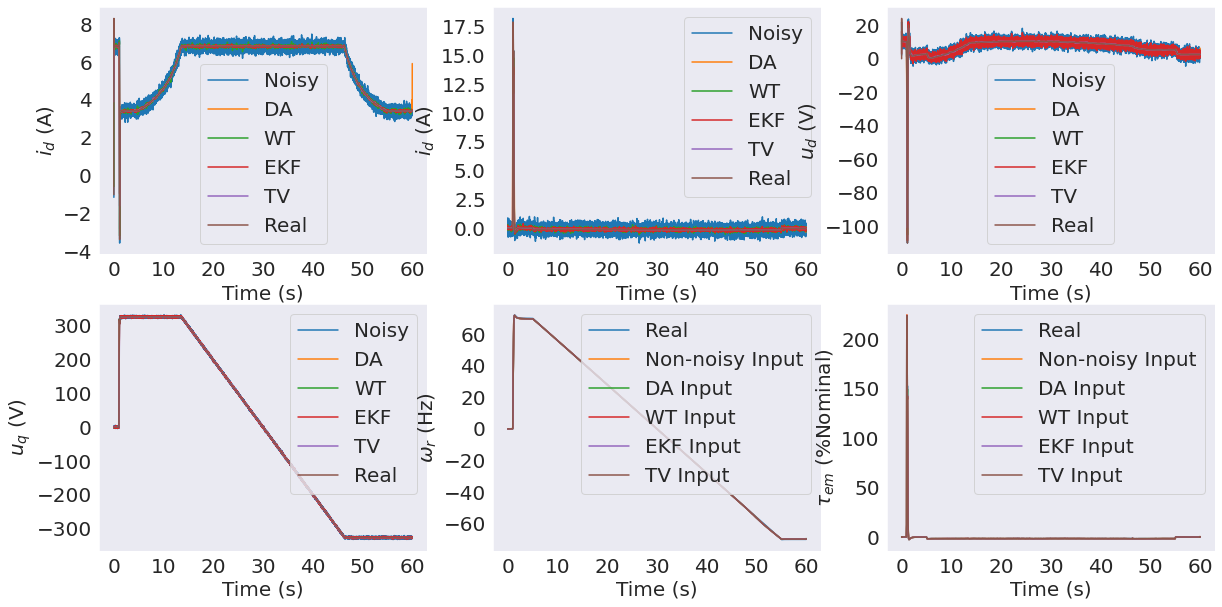

--------- Real -----------
{'perc2_times': [0.012, 1.008], 'perc95_times': [0.22, 47.5], 'following_errs': [69.7887, -0.0021], 'following_times': [1.004, 30.0], 'overshoot_errs': [3.1231, 0.088], 'overshoot_times': [1.376, 55.1], 'ramp_start_times': [1.0, 5.0], 'sse_errs': [-0.0037, -0.002], 'sse_times': [4.8, 59.8], 'max_trq_accs': [222.2401, 222.2401], 'max_trq_acc_times': [1.1, 1.1]}
{'perc2_times': [], 'perc95_times': [], 'following_errs': [], 'following_times': [], 'overshoot_errs': [], 'overshoot_times': [], 'ramp_start_times': [], 'sse_errs': [], 'sse_times': [], 'speed_drops': [], 'speed_drops_times': []}
--------- Non-Noisy ----------
{'perc2_times': [0.008, 0.968], 'perc95_times': [0.192, 47.344], 'following_errs': [69.1048, -0.0004], 'following_times': [1.004, 30.0], 'overshoot_errs': [2.6996, 0.005], 'overshoot_times': [1.372, 60.0], 'ramp_start_times': [1.0, 5.0], 'sse_errs': [0.2423, 0.1675], 'sse_times': [4.8, 59.8], 'max_trq_accs': [224.5082, 224.5082], 'max_trq_acc_tim

In [13]:
mat_files = glob.glob('../../../datasets/Data_27012021_noisy/benchmark/bench*.mat')
mat_files.sort()

alpha = 0.1

for mat_file in mat_files[4:5]:
    print (mat_file.split('/')[-1])
    
    data = loadmat(mat_file)

    st = 0
    w = -1

    x_id = np.stack([data['noisy_current_d'][0] / 30]) 
    x_iq = np.stack([data['noisy_current_q'][0] / 30])
    x_ud = np.stack([data['noisy_voltage_d'][0] / 300]) 
    x_uq = np.stack([data['noisy_voltage_q'][0] / 300])
    
    x = np.stack([data['current_d'][0] / 30, 
                      data['current_q'][0] / 30,
                      data['voltage_d'][0] / 300,
                      data['voltage_q'][0] / 300])


    inp_id = torch.tensor([x_id[:, st:st+w]]).cuda().float()
    out_id = model_id(inp_id)
    out_id_da = out_id.data.cpu().numpy()[0]
    out_id_wt = wt(data['noisy_current_d'][0], 0.17)
    out_id_ekf = ekf(data['noisy_current_d'][0], 0.17)
    out_id_tv = tv(data['noisy_current_d'][0], 0.17)

    inp_iq = torch.tensor([x_iq[:, st:st+w]]).cuda().float()
    out_iq = model_iq(inp_iq)
    out_iq_da = out_iq.data.cpu().numpy()[0]
    out_iq_wt = wt(data['noisy_current_q'][0], 0.29)
    out_iq_ekf = ekf(data['noisy_current_q'][0], 0.29)
    out_iq_tv = tv(data['noisy_current_q'][0], 0.29)

    inp_ud = torch.tensor([x_ud[:, st:st+w]]).cuda().float()
    out_ud = model_ud(inp_ud)
    out_ud_da = out_ud.data.cpu().numpy()[0]
    out_ud_wt = wt(data['noisy_voltage_d'][0], 1.85)
    out_ud_ekf = ekf(data['noisy_voltage_d'][0], 1.85)
    out_ud_tv = tv(data['noisy_voltage_d'][0], 1.85)

    inp_uq = torch.tensor([x_uq[:, st:st+w]]).cuda().float()
    out_uq = model_uq(inp_uq)
    out_uq_da = out_uq.data.cpu().numpy()[0]
    out_uq_wt = wt(data['noisy_voltage_q'][0], 1.78)
    out_uq_ekf = ekf(data['noisy_voltage_q'][0], 1.78)
    out_uq_tv = tv(data['noisy_voltage_q'][0], 1.78)
    
    inp = torch.tensor([x[:, st:st+w]]).cuda().float()
    out_spd = model_spd(inp)
    out_spd = out_spd.data.cpu().numpy()[0]
    
    out_trq = model_trq(inp)
    out_trq = out_trq.data.cpu().numpy()[0]

    inps_da = torch.from_numpy(np.stack([[out_id_da[0], 
                                           out_iq_da[0], 
                                           out_ud_da[0], 
                                           out_uq_da[0]]])).cuda()
    inps_wt = torch.from_numpy(np.stack([[out_id_wt / 30, 
                                           out_iq_wt / 30, 
                                           out_ud_wt / 300, 
                                           out_uq_wt / 300]])).cuda().float()
    inps_ekf = torch.from_numpy(np.stack([[out_id_ekf / 30, 
                                           out_iq_ekf / 30, 
                                           out_ud_ekf / 300, 
                                           out_uq_ekf / 300]])).cuda().float()
    inps_tv = torch.from_numpy(np.stack([[out_id_tv / 30, 
                                           out_iq_tv / 30, 
                                           out_ud_tv / 300, 
                                           out_uq_tv / 300]])).cuda().float()
    
    out_spd_da = model_spd(inps_da)
    out_spd_da = out_spd_da.data.cpu().numpy()[0]
    out_spd_wt = model_spd(inps_wt)
    out_spd_wt = out_spd_wt.data.cpu().numpy()[0]
    out_spd_ekf = model_spd(inps_ekf)
    out_spd_ekf = out_spd_ekf.data.cpu().numpy()[0]
    out_spd_tv = model_spd(inps_tv)
    out_spd_tv = out_spd_tv.data.cpu().numpy()[0]
    
    out_trq_da = model_trq(inps_da)
    out_trq_da = out_trq_da.data.cpu().numpy()[0]
    out_trq_wt = model_trq(inps_wt)
    out_trq_wt = out_trq_wt.data.cpu().numpy()[0]
    out_trq_ekf = model_trq(inps_ekf)
    out_trq_ekf = out_trq_ekf.data.cpu().numpy()[0]
    out_trq_tv = model_trq(inps_tv)
    out_trq_tv = out_trq_tv.data.cpu().numpy()[0]
    
    
    speed_pred = np.copy(data['speed'][0])
    speed_pred[:-1] = out_spd[0] * 80
    speed_pred = alpha * speed_pred + (1 - alpha) * data['speed'][0]

    torque_pred = np.copy(data['torque'][0])
    torque_pred[:-1] = out_trq[0] * 120
    torque_pred = alpha * torque_pred + (1 - alpha) * data['torque'][0]
    
    speed_pred_da = np.copy(data['speed'][0])
    speed_pred_da[:-1] = out_spd_da[0] * 80
    speed_pred_da = alpha * speed_pred_da + (1 - alpha) * data['speed'][0]

    torque_pred_da = np.copy(data['torque'][0])
    torque_pred_da[:-1] = out_trq_da[0] * 120
    torque_pred_da = alpha * torque_pred_da + (1 - alpha) * data['torque'][0]
    
    speed_pred_wt = out_spd_wt[0] * 80
    speed_pred_wt = alpha * speed_pred_wt + (1 - alpha) * data['speed'][0]

    torque_pred_wt = out_trq_wt[0] * 120
    torque_pred_wt = alpha * torque_pred_wt + (1 - alpha) * data['torque'][0]
    
    speed_pred_ekf = out_spd_ekf[0] * 80
    speed_pred_ekf = alpha * speed_pred_ekf + (1 - alpha) * data['speed'][0]

    torque_pred_ekf = out_trq_ekf[0] * 120
    torque_pred_ekf = alpha * torque_pred_ekf + (1 - alpha) * data['torque'][0]
    
    speed_pred_tv = out_spd_tv[0] * 80
    speed_pred_tv = alpha * speed_pred_tv + (1 - alpha) * data['speed'][0]

    torque_pred_tv = out_trq_tv[0] * 120
    torque_pred_tv = alpha * torque_pred_tv + (1 - alpha) * data['torque'][0]
    
    
    sns.set_style("dark")
    fig = plt.figure(figsize=(20,10))

    plt.subplot(2, 3, 1)
    plt.plot(data['time'][0, st:st+w], data['noisy_current_d'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_id_da[0] * 30, label='DA')
    plt.plot(data['time'][0, st:st+w], out_id_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_id_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_id_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['current_d'][0, st:st+w], label='Real')
    plt.ylabel(r'$i_d$ (A)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 2)
    plt.plot(data['time'][0, st:st+w], data['noisy_current_q'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_iq_da[0] * 30, label='DA')
    plt.plot(data['time'][0, st:st+w], out_iq_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_iq_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_iq_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['current_q'][0, st:st+w], label='Real')
    plt.ylabel(r'$i_d$ (A)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 3)
    plt.plot(data['time'][0, st:st+w], data['noisy_voltage_d'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_ud_da[0] * 300, label='DA')
    plt.plot(data['time'][0, st:st+w], out_ud_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_ud_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_ud_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['voltage_d'][0, st:st+w], label='Real')
    plt.ylabel(r'$u_d$ (V)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)

    plt.subplot(2, 3, 4)
    plt.plot(data['time'][0, st:st+w], data['noisy_voltage_q'][0, st:st+w], label='Noisy')
    plt.plot(data['time'][0, st:st+w], out_uq_da[0] * 300, label='DA')
    plt.plot(data['time'][0, st:st+w], out_uq_wt[st:st+w], label='WT')
    plt.plot(data['time'][0, st:st+w], out_uq_ekf[st:st+w], label='EKF')
    plt.plot(data['time'][0, st:st+w], out_uq_tv[st:st+w], label='TV')
    plt.plot(data['time'][0, st:st+w], data['voltage_q'][0, st:st+w], label='Real')
    plt.ylabel(r'$u_q$ (V)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.subplot(2, 3, 5)
    plt.plot(data['time'][0, st:st+w], data['speed'][0, st:st+w], label='Real')
    plt.plot(data['time'][0, st:st+w], speed_pred[st:st+w], label='Non-noisy Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_da[st:st+w], label='DA Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_wt[st:st+w], label='WT Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_ekf[st:st+w], label='EKF Input')
    plt.plot(data['time'][0, st:st+w], speed_pred_tv[st:st+w], label='TV Input')
    plt.ylabel(r'$\omega_r$ (Hz)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.subplot(2, 3, 6)
    plt.plot(data['time'][0, st:st+w], data['torque'][0, st:st+w], label='Real')
    plt.plot(data['time'][0, st:st+w], torque_pred[st:st+w], label='Non-noisy Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_da[st:st+w], label='DA Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_wt[st:st+w], label='WT Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_ekf[st:st+w], label='EKF Input')
    plt.plot(data['time'][0, st:st+w], torque_pred_tv[st:st+w], label='TV Input')
    plt.ylabel(r'$\tau_{em}$ (%Nominal)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    plt.show()
    
    print ('--------- Real -----------')
    compute_ee(data, data['speed'][0], data['torque'][0])
    
    print ('--------- Non-Noisy ----------')
    compute_ee(data, speed_pred, torque_pred)
    compute_ml(data, speed_pred, torque_pred)
    
    print ('------- DA --------')
    compute_ee(data, speed_pred_da, torque_pred_da)
    compute_ml(data, speed_pred_da, torque_pred_da)
    
    print ('------- WT --------')
    compute_ee(data, speed_pred_wt, torque_pred_wt)
    compute_ml(data, speed_pred_wt, torque_pred_wt)
    
    print ('------- EKF --------')
    compute_ee(data, speed_pred_ekf, torque_pred_ekf)
    compute_ml(data, speed_pred_ekf, torque_pred_ekf)
    
    print ('------- TV --------')
    compute_ee(data, speed_pred_tv, torque_pred_tv)
    compute_ml(data, speed_pred_tv, torque_pred_tv)